In [1]:
from datetime import datetime as dt
from arcgis.gis import GIS
from arcgis.geoanalytics.analyze_patterns import forest, glr
gis = GIS('https://ndhagsb01.esri.com/portal', 
          'admin', 
          'esri.agp2', 
          profile="your_enterprise_portal", verify_cert=False)

ConnectionError: A connection error has occurred: HTTPSConnectionPool(host='ndhagsb01.esri.com', port=443): Max retries exceeded with url: /portal/sharing/rest/info?f=json (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001BCB0DE6160>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond',))

In [2]:
import arcgis
arcgis.env.verbose = True

In [3]:
data = gis.content.search('timeseries_data_17_18_19_1station')[0]

In [4]:
series_data = data.tables[0]

In [39]:
df = series_data.query(as_df=True)

In [40]:
cols = ['Outdoor_Temperature', 'Ozone', 'PM10_Total_0_10um_STP',
        'PM2_5___Local_Conditions', 'Relative_Humidity',
        'Wind_Direction___Resultant',
        'Wind_Speed___Resultant', 'datetime']

In [41]:
df = df[cols]

In [42]:
import pandas as pd
from fbprophet import Prophet

In [43]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [44]:
df['Date'] = df['datetime'].astype('datetime64[ns]')

In [45]:
df['day'] = df['Date'].dt.day

In [46]:
df['year'] = df['Date'].dt.year

In [47]:
df['month'] = df['Date'].dt.month

In [113]:
df

,Outdoor_Temperature,Ozone,PM10_Total_0_10um_STP,PM2_5___Local_Conditions,Relative_Humidity,Wind_Direction___Resultant,Wind_Speed___Resultant,datetime,Date,day,year
0,86.9,0.033,23.0,15.7,50.0,206.0,9.2,2017-04-28 15:00,2017-04-28 15:00:00,28,2017
1,43.9,0.021,5.0,9.0,69.0,285.0,3.7,2017-11-19 07:00,2017-11-19 07:00:00,19,2017
2,66.2,0.007,50.0,19.0,69.0,150.0,2.0,2017-05-26 06:00,2017-05-26 06:00:00,26,2017
3,68.0,NaN,15.0,9.9,91.0,241.0,3.5,2017-03-28 07:00,2017-03-28 07:00:00,28,2017
4,73.6,0.027,NaN,12.9,70.0,216.0,7.6,2018-03-19 18:00,2018-03-19 18:00:00,19,2018
...,...,...,...,...,...,...,...,...,...,...,...
18226,59.5,0.030,10.0,12.8,72.0,216.0,2.6,2017-11-01 03:00,2017-11-01 03:00:00,1,2017
18227,42.1,0.011,NaN,12.6,93.0,104.0,3.6,2018-02-12 17:00,2018-02-12 17:00:00,12,2018
18228,69.4,0.002,24.0,15.8,85.0,143.0,1.2,2017-09-28 06:00,2017-09-28 06:00:00,28,2017
18229,68.5,NaN,NaN,NaN,80.0,176.0,5.5,2017-02-28 19:00,2017-02-28 19:00:00,28,2017


In [114]:
df_2018 = df[df.year == 2018]

In [115]:
df_2018

,Outdoor_Temperature,Ozone,PM10_Total_0_10um_STP,PM2_5___Local_Conditions,Relative_Humidity,Wind_Direction___Resultant,Wind_Speed___Resultant,datetime,Date,day,year
4,73.6,0.027,NaN,12.9,70.0,216.0,7.6,2018-03-19 18:00,2018-03-19 18:00:00,19,2018
6,55.0,0.003,36.0,12.6,48.0,119.0,1.0,2018-04-05 20:00,2018-04-05 20:00:00,5,2018
9,66.2,0.017,6.0,-5.3,93.0,169.0,3.6,2018-11-05 13:00,2018-11-05 13:00:00,5,2018
11,85.1,0.040,12.0,-1.0,71.0,111.0,3.0,2018-09-12 15:00,2018-09-12 15:00:00,12,2018
12,75.0,0.043,30.0,16.5,50.0,275.0,6.0,2018-04-18 19:00,2018-04-18 19:00:00,18,2018
...,...,...,...,...,...,...,...,...,...,...,...
18221,69.8,0.003,21.0,8.7,98.0,152.0,1.2,2018-06-12 02:00,2018-06-12 02:00:00,12,2018
18223,48.7,0.020,7.8,3.5,99.0,129.0,NaN,2018-12-20 23:00,2018-12-20 23:00:00,20,2018
18224,48.4,0.015,NaN,7.9,95.0,239.0,3.6,2018-02-12 00:00,2018-02-12 00:00:00,12,2018
18225,41.2,0.024,NaN,7.0,62.0,73.0,4.3,2018-01-23 21:00,2018-01-23 21:00:00,23,2018


In [116]:
df_2018.set_index('Date', inplace=True)

In [118]:
vdf= df_2018[['Outdoor_Temperature', 'Ozone', 'PM10_Total_0_10um_STP',
        'PM2_5___Local_Conditions', 'Relative_Humidity',
        'Wind_Direction___Resultant',
        'Wind_Speed___Resultant']]

<Figure size 720x864 with 0 Axes>

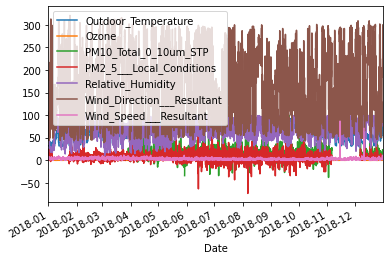

In [120]:
plt.figure(figsize=(10, 12))
vdf.plot()

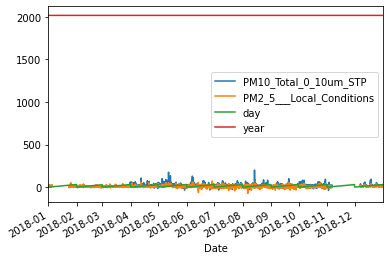

In [105]:
df_2018.plot()

In [121]:
import seaborn as sns

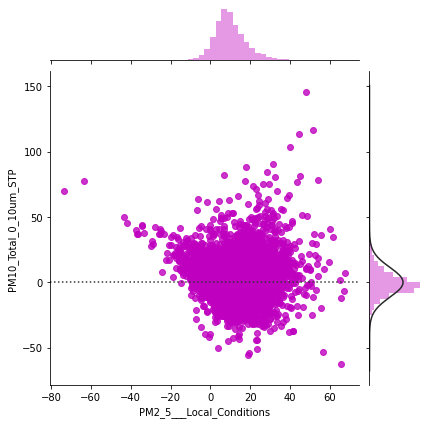

In [122]:
g = sns.jointplot(x=df.PM2_5___Local_Conditions, y=df.PM10_Total_0_10um_STP, kind="resid", data=df, color="m")

In [123]:
df

,Outdoor_Temperature,Ozone,PM10_Total_0_10um_STP,PM2_5___Local_Conditions,Relative_Humidity,Wind_Direction___Resultant,Wind_Speed___Resultant,datetime,Date,day,year
0,86.9,0.033,23.0,15.7,50.0,206.0,9.2,2017-04-28 15:00,2017-04-28 15:00:00,28,2017
1,43.9,0.021,5.0,9.0,69.0,285.0,3.7,2017-11-19 07:00,2017-11-19 07:00:00,19,2017
2,66.2,0.007,50.0,19.0,69.0,150.0,2.0,2017-05-26 06:00,2017-05-26 06:00:00,26,2017
3,68.0,NaN,15.0,9.9,91.0,241.0,3.5,2017-03-28 07:00,2017-03-28 07:00:00,28,2017
4,73.6,0.027,NaN,12.9,70.0,216.0,7.6,2018-03-19 18:00,2018-03-19 18:00:00,19,2018
...,...,...,...,...,...,...,...,...,...,...,...
18226,59.5,0.030,10.0,12.8,72.0,216.0,2.6,2017-11-01 03:00,2017-11-01 03:00:00,1,2017
18227,42.1,0.011,NaN,12.6,93.0,104.0,3.6,2018-02-12 17:00,2018-02-12 17:00:00,12,2018
18228,69.4,0.002,24.0,15.8,85.0,143.0,1.2,2017-09-28 06:00,2017-09-28 06:00:00,28,2017
18229,68.5,NaN,NaN,NaN,80.0,176.0,5.5,2017-02-28 19:00,2017-02-28 19:00:00,28,2017


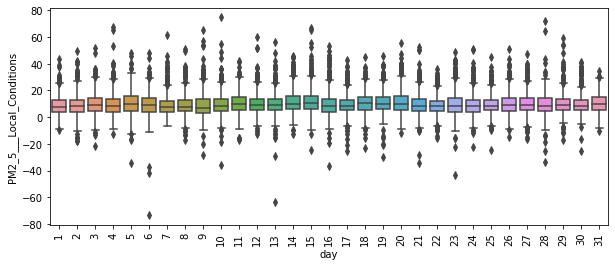

In [136]:
f, ax = plt.subplots(figsize=(10, 4))
fig = sns.boxplot(x='day', y="PM2_5___Local_Conditions", data=df);
plt.xticks(rotation=90);

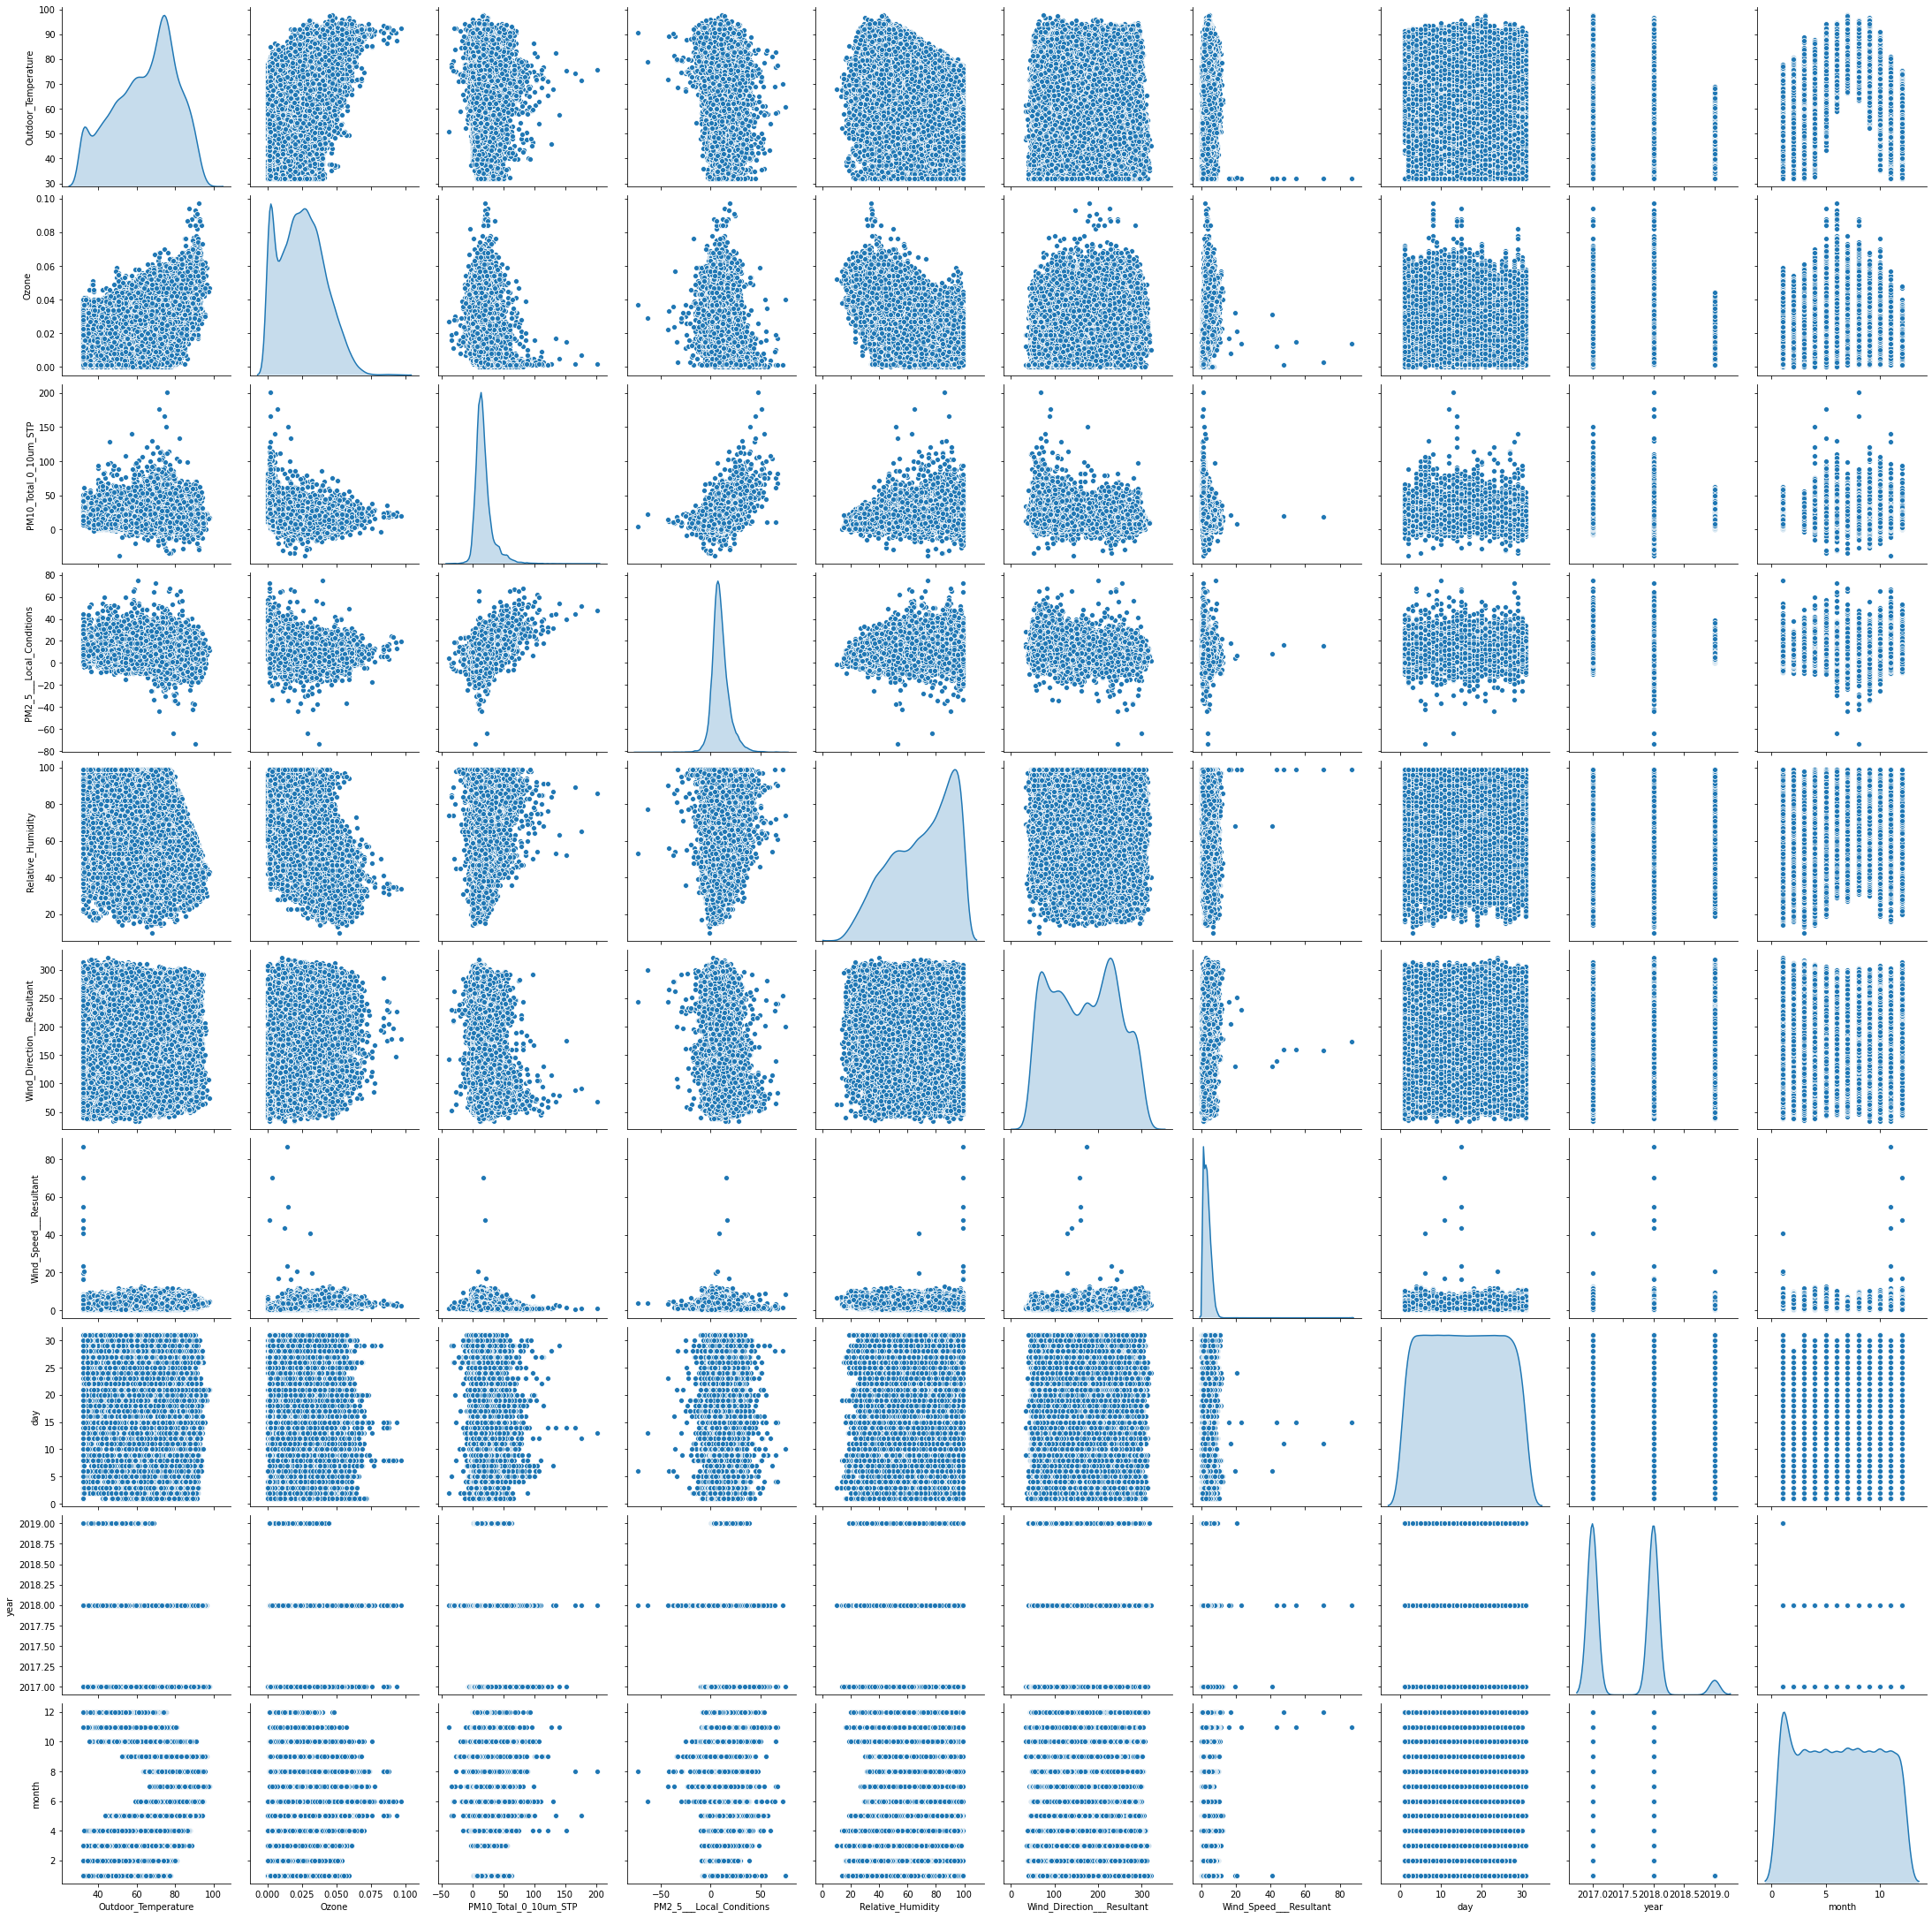

In [140]:
sns.pairplot(df, diag_kind="kde", size=3)

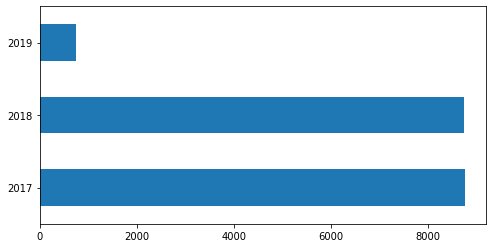

In [139]:
df.year.value_counts().plot(kind='barh', figsize=(8, 4))

In [21]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [48]:
df_pm = df[['Date', 'PM2_5___Local_Conditions', 'year']]

In [49]:
df_pm

,Date,PM2_5___Local_Conditions,year
0,2017-04-28 15:00:00,15.7,2017
1,2017-11-19 07:00:00,9.0,2017
2,2017-05-26 06:00:00,19.0,2017
3,2017-03-28 07:00:00,9.9,2017
4,2018-03-19 18:00:00,12.9,2018
...,...,...,...
18226,2017-11-01 03:00:00,12.8,2017
18227,2018-02-12 17:00:00,12.6,2018
18228,2017-09-28 06:00:00,15.8,2017
18229,2017-02-28 19:00:00,NaN,2017


In [50]:
train_df = df_pm[df_pm.year != 2019]

In [51]:
df.rename(columns={'Date': 'ds', 'PM2_5___Local_Conditions': 'y'}, inplace=True)

In [52]:
train_df.rename(columns={'Date': 'ds', 'PM2_5___Local_Conditions': 'y'}, inplace=True)

In [53]:
train_df.sort_values('ds', inplace=True)

In [54]:
train_df.fillna(0, inplace=True)

In [55]:
for i,item in enumerate(train_df['y']):
    if item<=0:
        train_df['y'].iloc[i]=train_df['y'].iloc[i-1]
    else:
        train_df['y'].iloc[i]=item

In [59]:
train_df.tail()

,ds,y,year
3907,2018-12-31 19:00:00,2.7,2018
3199,2018-12-31 20:00:00,3.4,2018
3304,2018-12-31 21:00:00,4.3,2018
12768,2018-12-31 22:00:00,5.5,2018
6547,2018-12-31 23:00:00,5.2,2018


In [56]:
test_df = df_pm[df_pm.year == 2019]

In [60]:
test_df.sort_values('Date', inplace=True)

In [61]:
test_df.tail()

,Date,PM2_5___Local_Conditions,year
2750,2019-01-31 19:00:00,9.9,2019
1161,2019-01-31 20:00:00,10.5,2019
14760,2019-01-31 21:00:00,13.6,2019
5654,2019-01-31 22:00:00,15.0,2019
2176,2019-01-31 23:00:00,15.2,2019


In [63]:
train_df.set_index('ds', inplace=True)

In [64]:
train_df = train_df[['y']]

In [71]:
tr = train_df.resample('D').mean()

In [74]:
tr.reset_index(inplace=True)

In [76]:
tr

,ds,y
0,2017-01-01,5.045833
1,2017-01-02,3.195833
2,2017-01-03,5.991667
3,2017-01-04,6.833333
4,2017-01-05,7.208333
...,...,...
725,2018-12-27,6.758333
726,2018-12-28,4.983333
727,2018-12-29,8.954167
728,2018-12-30,6.429167


In [77]:
m = Prophet(daily_seasonality=True)
m.fit(tr);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [78]:
future = m.make_future_dataframe(periods=30)
future.tail(n=3)

,ds
757,2019-01-28
758,2019-01-29
759,2019-01-30


In [79]:
future

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
755,2019-01-26
756,2019-01-27
757,2019-01-28
758,2019-01-29


In [80]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
757,2019-01-28,4.140940,2.759503,14.782716,4.131580,4.150587,4.668683,4.668683,4.668683,4.85743,4.85743,4.85743,-0.188746,-0.188746,-0.188746,0.0,0.0,0.0,8.809624
758,2019-01-29,4.131219,3.620790,15.109400,4.121261,4.141829,5.349715,5.349715,5.349715,4.85743,4.85743,4.85743,0.492286,0.492286,0.492286,0.0,0.0,0.0,9.480934
759,2019-01-30,4.121498,3.492697,15.327295,4.110928,4.132592,5.208939,5.208939,5.208939,4.85743,4.85743,4.85743,0.351510,0.351510,0.351510,0.0,0.0,0.0,9.330437


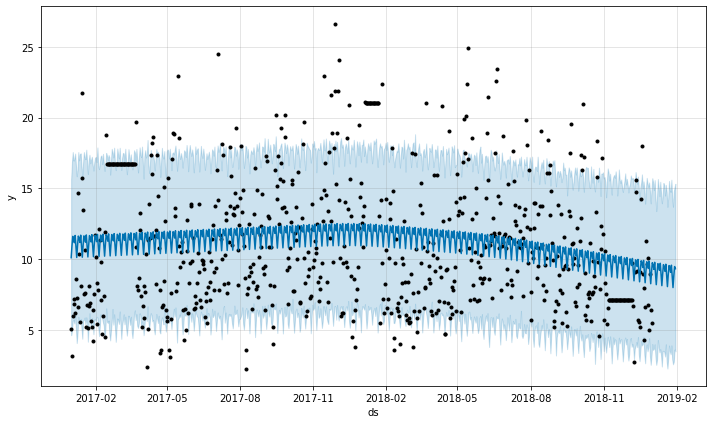

In [81]:
m.plot(forecast);

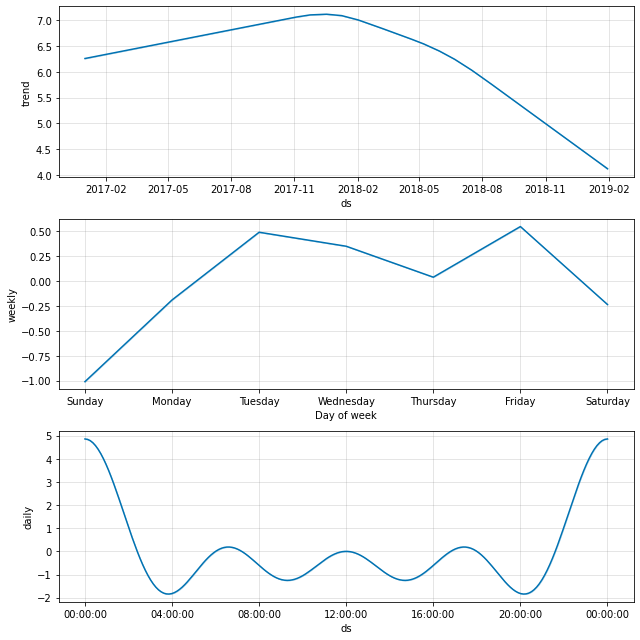

In [82]:
m.plot_components(forecast);

In [83]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


In [84]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,Outdoor_Temperature,Ozone,PM10_Total_0_10um_STP,y,Relative_Humidity,Wind_Direction___Resultant,Wind_Speed___Resultant,datetime,day,year,month
ds,,,,,,,,,,,,,,
2019-01-28,8.809624,2.759503,14.782716,37.9,0.001,36.3,24.0,99.0,71.0,0.8,2019-01-28 00:00,28,2019,1
2019-01-29,9.480934,3.620790,15.109400,49.8,0.037,18.0,12.1,81.0,302.0,5.2,2019-01-29 00:00,29,2019,1
2019-01-30,9.330437,3.492697,15.327295,32.0,0.007,15.1,10.2,37.0,268.0,0.6,2019-01-30 00:00,30,2019,1


In [85]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}


In [86]:
for err_name, err_value in calculate_forecast_errors(cmp_df, 30).items():
    print(err_name, err_value)

MAPE 120.46890345950685
MAE 5.733641257483982


using box-cox

In [87]:
train_df2 = tr.copy().set_index('ds')

In [88]:
train_df2

,y
ds,
2017-01-01,5.045833
2017-01-02,3.195833
2017-01-03,5.991667
2017-01-04,6.833333
2017-01-05,7.208333
...,...
2018-12-27,6.758333
2018-12-28,4.983333
2018-12-29,8.954167


In [89]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [91]:
m2 = Prophet(daily_seasonality=True)
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30, freq='d', include_history=True)
forecast2 = m2.predict(future2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [92]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [93]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [94]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, 30).items():
    print(err_name, err_value)

MAPE 111.27605583808916
MAE 5.738886457522753


In [95]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [96]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, 30, 100, 'New posts on Medium')

In [97]:
show_forecast(cmp_df, 30, 100, 'No transformations')
show_forecast(cmp_df2, 30, 100, 'Box–Cox transformation')

https://mode.com/example-gallery/forecasting_prophet_python_cookbook/

https://databricks.com/blog/2020/01/27/time-series-forecasting-prophet-spark.html

https://towardsdatascience.com/pyspark-forecasting-with-pandas-udf-and-fb-prophet-e9d70f86d802

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

https://mlcourse.ai/articles/topic9-part2-prophet/

https://stackoverflow.com/questions/53339783/fbprophet-predict-a-future-holiday
    
https://stackoverflow.com/questions/54544285/is-it-possible-to-do-multivariate-multi-step-forecasting-using-fb-prophet

https://stackoverflow.com/questions/58803505/measure-model-accuracy-on-prophet